# Applying K-Nearest Neighbors (KNN) Algorithm

This notebook explores the application of the K-Nearest Neighbors (KNN) algorithm to our data. We will use the KNN algorithm, play with its parameters and analyze its performance in making predictions based on our dataset.

Here, we will:

* Apply KNN to our data for regression and try different combinitions of it parameters.
* Evaluate the KNN model's performance using metrics Mean Squared Error, R-squared, and Mean Absolute Error
* Explore the impact of different parameters values on the model's performance.



In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler


In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [19]:
from sklearn.model_selection import cross_val_score

## Initial Modeling Approach: Raw Data

We will begin our exploration by applying the KNN algorithm directly to the original data, **without** any preprocessing steps. This initial approach will serve as a baseline for comparison as we investigate the potential benefits of data preprocessing techniques we applied.





In [68]:
models_results = []

In [69]:
df_original = pd.read_csv('data/data.csv')

df_original.drop("DateTime", inplace=True, axis=1)

df_z1_original = df_original.drop(["Zone 2  Power Consumption", "Zone 3  Power Consumption"], axis=1)
df_z2_original = df_original.drop(["Zone 1 Power Consumption", "Zone 3  Power Consumption"], axis=1)
df_z3_original = df_original.drop(["Zone 1 Power Consumption", "Zone 2  Power Consumption"], axis=1)

In [70]:
zones_original = [df_z1_original, df_z2_original, df_z3_original]
targets_original = ["Zone 1 Power Consumption", "Zone 2  Power Consumption", "Zone 3  Power Consumption"]

In [71]:
def evaluate_model(model, X_train, y_train, X_test, y_test, zone="Whole City"):
    # Predict on training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics for training data
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate metrics for testing data
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print the metrics
    print(f"Model: {model}")
    print("====== Train ========")
    print(f"Training MSE: {train_mse:.7f}")
    print(f"Training MAE: {train_mae:.7f}")
    print(f"Training R-squared: {train_r2:.7f}")
    print("====== Test ========")
    print(f"Testing MSE: {test_mse:.7f}")
    print(f"Testing MAE: {test_mae:.7f}")
    print(f"Testing R-squared: {test_r2:.7f}")
    
    new_row = {
        "Zone": zone,
        "Model": str(model),
        "Train MSE": train_mse,
        "Train MAE": train_mae,
        "Train R2": train_r2,
        "Test MSE": test_mse,
        "Test MAE": test_mae,
        "Test R2": test_r2
    }
    
  
    models_results.append(new_row)

    


In this part, we employed the KNN algorithm as our **base model** to evaluate its performance on the raw data. We analyzed metrics like [accuracy/mean squared error] (depending on your task) to assess the model's effectiveness in making predictions or classifications.


In [72]:
for zone, target in zip(zones_original, targets_original):
    print(f"===================  {target}  ==================")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    #fit the knn model
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)

    evaluate_model(knn, X_train, y_train, X_test, y_test)
                

===================  Zone 1 Power Consumption  ==================
Model: KNeighborsRegressor()
====== Train ========
Training MSE: 0.3665647
Training MAE: 0.4012962
Training R-squared: 0.6334353
====== Test ========
Testing MSE: 0.5611122
Testing MAE: 0.5060919
Testing R-squared: 0.4340413
===================  Zone 2  Power Consumption  ==================
Model: KNeighborsRegressor()
====== Train ========
Training MSE: 0.3776392
Training MAE: 0.4150653
Training R-squared: 0.6223608
====== Test ========
Testing MSE: 0.5764644
Testing MAE: 0.5208012
Testing R-squared: 0.4218060
===================  Zone 3  Power Consumption  ==================
Model: KNeighborsRegressor()
====== Train ========
Training MSE: 0.2546336
Training MAE: 0.3366834
Training R-squared: 0.7453664
====== Test ========
Testing MSE: 0.3944382
Testing MAE: 0.4328279
Testing R-squared: 0.6027717


In [75]:
models_results

[{'Model': 'KNeighborsRegressor()',
  'Train MSE': 0.36656469254220636,
  'Train MAE': 0.40129617082194813,
  'Train R2': 0.6334353074577936,
  'Test MSE': 0.5611122346099089,
  'Test MAE': 0.5060918582311908,
  'Test R2': 0.4340413310428214},
 {'Model': 'KNeighborsRegressor()',
  'Train MSE': 0.37763922579799886,
  'Train MAE': 0.4150652917275521,
  'Train R2': 0.622360774202001,
  'Test MSE': 0.5764644292176823,
  'Test MAE': 0.5208011887465879,
  'Test R2': 0.4218059865684186},
 {'Model': 'KNeighborsRegressor()',
  'Train MSE': 0.25463363220301427,
  'Train MAE': 0.3366833505471478,
  'Train R2': 0.7453663677969857,
  'Test MSE': 0.39443822586743565,
  'Test MAE': 0.43282788660812993,
  'Test R2': 0.6027716937615772},
 {'Model': "KNeighborsRegressor(metric='manhattan', n_neighbors=7)",
  'Train MSE': 0.3970462068595061,
  'Train MAE': 0.4302117400187825,
  'Train R2': 0.602953793140494,
  'Test MSE': 0.5386047959643964,
  'Test MAE': 0.5060854148354953,
  'Test R2': 0.45674317076710

In [24]:
param_grid = {
    'n_neighbors': range(1, 11),  # Experiment with different k values
    'algorithm': ['auto', 'kd_tree'],  # Experiment with different algorithms (optional)
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Try different distance metrics
}


In [74]:
for zone, target in zip(zones_original, targets_original):
    print(f"===================  {target}  ==================")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    # Create a kNN regressor with GridSearchCV for hyperparameter tuning
    knn_reg = KNeighborsRegressor()
    grid_search = GridSearchCV(knn_reg, param_grid, scoring='neg_mean_squared_error')  # Minimize MSE

    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    print(f"Best model: {best_model}")
    
    evaluate_model(best_model, X_train, y_train, X_test, y_test)
    





                            

===================  Zone 1 Power Consumption  ==================
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
====== Train ========
Training MSE: 0.3970462
Training MAE: 0.4302117
Training R-squared: 0.6029538
====== Test ========
Testing MSE: 0.5386048
Testing MAE: 0.5060854
Testing R-squared: 0.4567432
===================  Zone 2  Power Consumption  ==================
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
====== Train ========
Training MSE: 0.4096149
Training MAE: 0.4442301
Training R-squared: 0.5903851
====== Test ========
Testing MSE: 0.5524593
Testing MAE: 0.5195120
Testing R-squared: 0.4458831
===================  Zone 3  Power Consumption  ==================
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
====== Train ========

=================== Zone 1 Power Consumption ==================
Best score is 0.43477954426341087
Best K is 8


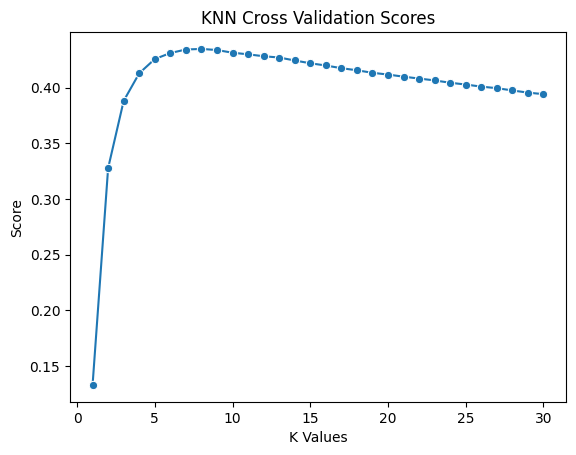

=================== Zone 2  Power Consumption ==================
Best score is 0.41151323365453046
Best K is 8


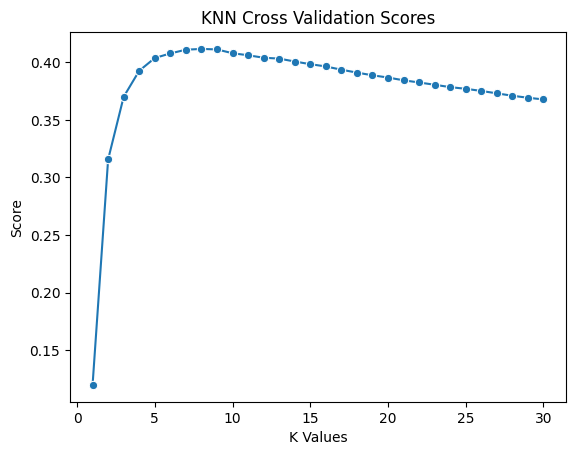

=================== Zone 3  Power Consumption ==================
Best score is 0.5971893089288354
Best K is 7


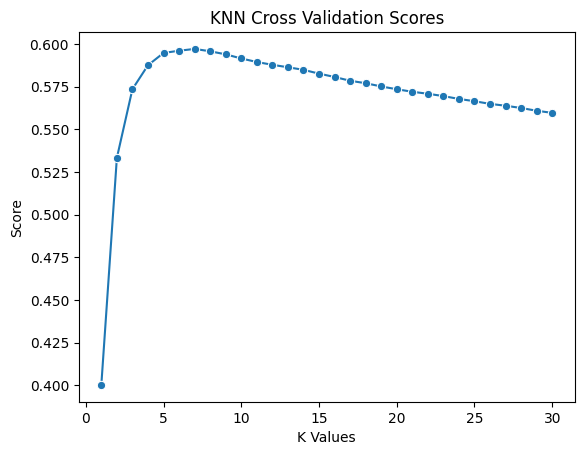

In [26]:
for zone, target in zip(zones_original, targets_original):
    print(f"=================== {target} ==================")
    X = zone.drop(target, axis=1)
    y = zone[target]

    k_values = [i for i in range(1, 31)]
    scores = []
    best_score = -float('inf')
    best_k = None

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        score = np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring='r2'))
        scores.append(score)
        if score > best_score:
            best_score = score
            best_k = k

    sns.lineplot(x=k_values, y=scores, marker='o')
    
    print(f"Best score is {best_score}")
    print(f"Best K is {best_k}")

    plt.xlabel(f"K Values")
    plt.ylabel("Score")
    plt.title("KNN Cross Validation Scores")
    plt.show()

# Preprocessed Data Modeling

In [27]:
df = pd.read_csv("data/data-ready.csv")
df

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,z1,z2,z3,Year,...,Day,Hour,IsWeekend,IsNight,HourCos,HourSin,MonthCos,MonthSin,DayCos,DaySin
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52412,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52413,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52414,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299


In [28]:
df.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,z1,z2,z3,Year,Month,Day,Hour,IsWeekend,IsNight,HourCos,HourSin,MonthCos,MonthSin,DayCos,DaySin
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.0,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,5.241600e+04,5.241600e+04,5.241600e+04,5.241600e+04,52416.000000,5.241600e+04
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218,2017.0,6.510989,15.678571,11.500000,0.285714,0.458333,-6.940588e-17,-1.918151e-17,-5.126443e-03,-5.395884e-03,-0.021699,1.636413e-03
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099,0.0,3.440642,8.771822,6.922253,0.451758,0.498266,7.071135e-01,7.071135e-01,7.075804e-01,7.066071e-01,0.699348,7.144631e-01
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070,2017.0,1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-0.994869,-9.987165e-01
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630,2017.0,4.000000,8.000000,5.750000,0.000000,0.000000,-7.071068e-01,-7.071068e-01,-8.660254e-01,-8.660254e-01,-0.758758,-7.247928e-01
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470,2017.0,7.000000,16.000000,11.500000,0.000000,0.000000,-6.123234e-17,6.123234e-17,-1.836970e-16,-2.449294e-16,-0.050649,-2.449294e-16
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420,2017.0,9.250000,23.000000,17.250000,1.000000,1.000000,7.071068e-01,7.071068e-01,5.915064e-01,5.000000e-01,0.688967,7.247928e-01
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360,2017.0,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,9.987165e-01


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DateTime               52416 non-null  object 
 1   Temperature            52416 non-null  float64
 2   Humidity               52416 non-null  float64
 3   Wind Speed             52416 non-null  float64
 4   general diffuse flows  52416 non-null  float64
 5   diffuse flows          52416 non-null  float64
 6   z1                     52416 non-null  float64
 7   z2                     52416 non-null  float64
 8   z3                     52416 non-null  float64
 9   Year                   52416 non-null  int64  
 10  Month                  52416 non-null  int64  
 11  Day                    52416 non-null  int64  
 12  Hour                   52416 non-null  int64  
 13  IsWeekend              52416 non-null  int64  
 14  IsNight                52416 non-null  int64  
 15  Ho

In [30]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,z1,z2,z3,Year,...,Day,Hour,IsWeekend,IsNight,HourCos,HourSin,MonthCos,MonthSin,DayCos,DaySin
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52412,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52413,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52414,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299


In [31]:
df = df.drop("DateTime", axis=1)

<Axes: xlabel='Temperature', ylabel='Humidity'>

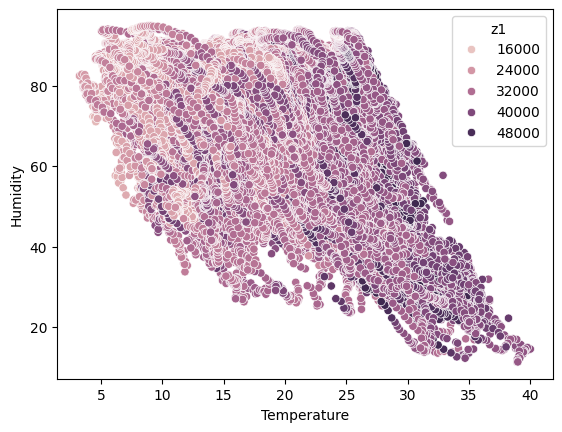

In [32]:

sns.scatterplot(x=df['Temperature'],y=df['Humidity'], hue=df['z1'])

In [33]:
df.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
       'diffuse flows', 'z1', 'z2', 'z3', 'Year', 'Month', 'Day', 'Hour',
       'IsWeekend', 'IsNight', 'HourCos', 'HourSin', 'MonthCos', 'MonthSin',
       'DayCos', 'DaySin'],
      dtype='object')

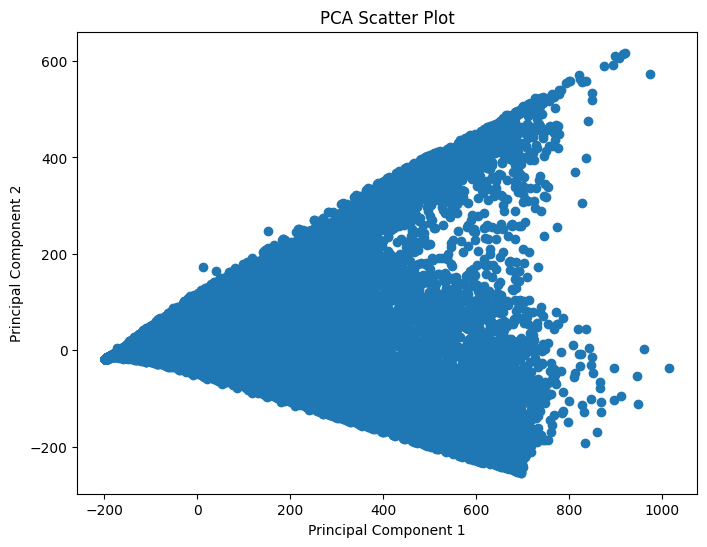

In [34]:

features = ['Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows']

# Create a PCA object. Here, we choose to reduce the data to 2 dimensions for visualization
pca = PCA(n_components=2)

# Apply PCA to the data
pca_data = pca.fit_transform(df[features])

# Extract the principal components
pc1 = pca_data[:, 0]
pc2 = pca_data[:, 1]

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2)

# Label the axes based on the principal components
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Add a title
plt.title("PCA Scatter Plot")

# Show the plot
plt.show()


In [35]:
df_z1 = df.drop(["z2", "z3"], axis=1)
df_z2 = df.drop(["z1", "z3"], axis=1)
df_z3 = df.drop(["z1", "z2"], axis=1)

# We will conside reach zone alone

In [36]:
zones = [df_z1, df_z2, df_z3]
targets = ["z1", "z2", "z3"]

In [37]:
for zone, target in zip(zones, targets):
    print(f"===================  {target}  ==================")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    #fit the knn model
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)
    print(f"{knn}")


    evaluate_model(knn, X_train, y_train, X_test, y_test)





                            

===================  z1  ==================
KNeighborsRegressor(n_neighbors=3)
Model: KNeighborsRegressor(n_neighbors=3)
====== Train ========
Training MSE: 0.0073046
Training MAE: 0.0513714
Training R-squared: 0.9926954
====== Test ========
Testing MSE: 0.0184326
Testing MAE: 0.0871861
Testing R-squared: 0.9814082
===================  z2  ==================
KNeighborsRegressor(n_neighbors=3)
Model: KNeighborsRegressor(n_neighbors=3)
====== Train ========
Training MSE: 0.0061884
Training MAE: 0.0476955
Training R-squared: 0.9938116
====== Test ========
Testing MSE: 0.0156941
Testing MAE: 0.0816851
Testing R-squared: 0.9842588
===================  z3  ==================
KNeighborsRegressor(n_neighbors=3)
Model: KNeighborsRegressor(n_neighbors=3)
====== Train ========
Training MSE: 0.0036183
Training MAE: 0.0340763
Training R-squared: 0.9963817
====== Test ========
Testing MSE: 0.0091902
Testing MAE: 0.0578896
Testing R-squared: 0.9907448


## We will go for grid search to find the best parameters for Knn

In [40]:
for zone, target in zip(zones, targets):
    print(f"===================  {target}  ==================")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    # Create a kNN regressor with GridSearchCV for hyperparameter tuning
    knn_reg = KNeighborsRegressor()
    grid_search = GridSearchCV(knn_reg, param_grid, scoring='r2')  # Minimize MSE

    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    print(f"Best model: {best_model}")


    
    evaluate_model(best_model, X_train, y_train, X_test, y_test)





                            

===================  z1  ==================
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=1)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=1)
====== Train ========
Training MSE: 0.0000000
Training MAE: 0.0000000
Training R-squared: 1.0000000
====== Test ========
Testing MSE: 0.0154539
Testing MAE: 0.0794098
Testing R-squared: 0.9844127
===================  z2  ==================
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=1)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=1)
====== Train ========
Training MSE: 0.0000000
Training MAE: 0.0000000
Training R-squared: 1.0000000
====== Test ========
Testing MSE: 0.0133496
Testing MAE: 0.0735949
Testing R-squared: 0.9866103
===================  z3  ==================
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=2)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=2)
====== Train ========
Training MSE: 0.0020614
Training MAE: 0.0268156
Training R-squared:

## We will use now cross validation

In [85]:
from sklearn.model_selection import StratifiedKFold

In [89]:
for zone, target in zip(zones, targets):
    print(f"=================== {target} ==================")
    X = zone.drop(target, axis=1)
    y = zone[target]

    k_values = [i for i in range(1, 31)]
    scores = []
    best_score = -float('inf')
    best_k = None

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        score = np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring='r2'))
        scores.append(score)
        if score > best_score:
            best_score = score
            best_k = k

    sns.lineplot(x=k_values, y=scores, marker='o')
    
    print(f"Best score is {best_score}")
    print(f"Best K is {best_k}")

    plt.xlabel(f"K Values")
    plt.ylabel("Score")
    plt.title("KNN Cross Validation Scores")
    plt.show()

ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

# we will consider the whole city

In [ ]:
df["city_consumption"] = df_z1["z1"] + df_z2["z2"] + df_z3["z3"]
df.drop(["z1", "z2", "z3"], axis=1,inplace=True)
df

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Year,Month,Day,Hour,IsWeekend,IsNight,HourCos,HourSin,MonthCos,MonthSin,DayCos,DaySin,city_consumption
0,6.559,73.8,0.083,0.051,0.119,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,70425.53544
1,6.414,74.5,0.083,0.070,0.085,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,69320.84387
2,6.313,74.5,0.080,0.062,0.100,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,67803.22193
3,6.121,75.0,0.083,0.091,0.096,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,65489.23209
4,5.921,75.7,0.081,0.048,0.085,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,63650.44627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,7.010,72.4,0.080,0.040,0.096,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,72798.08659
52412,6.947,72.6,0.082,0.051,0.093,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,70983.80786
52413,6.900,72.8,0.086,0.084,0.074,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,68675.04965
52414,6.758,73.0,0.080,0.066,0.089,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,67163.01682


In [ ]:
target = "city_consumption"

In [ ]:
print(f"===================  Whole city  ==================")
X = df.drop(target, axis=1)
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

#fit the knn model
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
print(f"{knn}")


#make the predictions
y_pred = knn.predict(X_test)

#evaluate the model 
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

MSE = mean_squared_error(y_test, y_pred)
print("mean_squared_error:", MSE)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

                        

===================  Whole city  ==================
KNeighborsRegressor()
R-squared: 0.9817
mean_squared_error: 0.018144993210156245
Mean Absolute Error: 0.09


In [ ]:
print(f"===================  Whole city  ==================")
X = df.drop(target, axis=1)
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Create a kNN regressor with GridSearchCV for hyperparameter tuning
knn_reg = KNeighborsRegressor()
grid_search = GridSearchCV(knn_reg, param_grid, scoring='neg_mean_squared_error')  # Minimize MSE

grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_
print(f"Best model: {best_model}")


# Make predictions on the testing data using the best model
y_pred = best_model.predict(X_test)

#evaluate the model 
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

MSE = mean_squared_error(y_test, y_pred)
print("mean_squared_error:", MSE)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")




                        

===================  Whole city  ==================
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=1)
R-squared: 0.9872
mean_squared_error: 0.012635392361731165
Mean Absolute Error: 0.07


===================  Whole city  ==================
Best score is 0.9836684989087395
Best K is 2


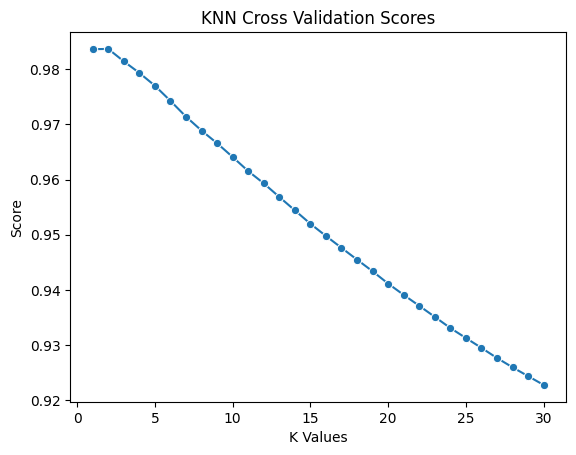

In [ ]:
print(f"===================  Whole city  ==================")
X = df.drop(target, axis=1)
y = df[target]

k_values = [i for i in range(1, 31)]
scores = []
best_score = -float('inf')
best_k = None

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    score = np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring='r2'))
    scores.append(score)
    if score > best_score:
        best_score = score
        best_k = k

sns.lineplot(x=k_values, y=scores, marker='o')

print(f"Best score is {best_score}")
print(f"Best K is {best_k}")

plt.xlabel(f"K Values")
plt.ylabel("Score")
plt.title("KNN Cross Validation Scores")
plt.show()

In [76]:
results = pd.DataFrame(models_results)
results

,Model,Train MSE,Train MAE,Train R2,Test MSE,Test MAE,Test R2
0,KNeighborsRegressor(),0.366565,0.401296,0.633435,0.561112,0.506092,0.434041
1,KNeighborsRegressor(),0.377639,0.415065,0.622361,0.576464,0.520801,0.421806
2,KNeighborsRegressor(),0.254634,0.336683,0.745366,0.394438,0.432828,0.602772
3,"KNeighborsRegressor(metric='manhattan', n_neig...",0.397046,0.430212,0.602954,0.538605,0.506085,0.456743
4,"KNeighborsRegressor(metric='manhattan', n_neig...",0.409615,0.444230,0.590385,0.552459,0.519512,0.445883
5,"KNeighborsRegressor(metric='manhattan', n_neig...",0.277283,0.362645,0.722717,0.382125,0.433901,0.615172


In [83]:
# Plotting using Seaborn
sns.set(style="whitegrid")

# Plotting for Train MSE vs Zone
plt.figure()
sns.barplot(x="Zone", y="Train MSE", hue="Model", data=results)
plt.title("Train MSE vs Zone")
plt.xlabel("Zone")
plt.ylabel("Train MSE")
plt.show()

# Plotting for Test R2 vs Zone
plt.figure()
sns.barplot(x="Zone", y="Test R2", hue="Model", data=results)
plt.title("Test R2 vs Zone")
plt.xlabel("Zone")
plt.ylabel("Test R2")
plt.show()


ValueError: Could not interpret value `Zone` for `x`. An entry with this name does not appear in `data`.

<Figure size 640x480 with 0 Axes>